# Cybersecurity RAG Evaluation Notebook

This notebook allows for an interactive evaluation of the RAG pipeline. It performs the same function as `scripts/run_evaluation.py` but provides a step-by-step execution with visible logs and outputs, including a confusion matrix chart.

In [6]:
!rm -rf /kaggle/working/*

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [7]:
!git clone https://github.com/luthfiarifin/rag-cybersecurity-eval code
!mv code/* .
!ls

Cloning into 'code'...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 139 (delta 4), reused 8 (delta 3), pack-reused 123 (from 1)
Receiving objects: 100% (139/139), 80.28 MiB | 54.48 MiB/s, done.
Resolving deltas: 100% (33/33), done.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


1_build_vector_store.ipynb  app.py  data       requirements.txt
2_evaluation.ipynb	    code    readme.md  src


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Setup Environment

In [8]:
# !pip install -r requirements.txt

### Import Libraries and Load Configuration

In [9]:
# !pip install numpy==1.26.4

import sys
import os
import pandas as pd
from dotenv import load_dotenv
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

from src.config import Config
from src.rag_pipeline.graph import build_rag_graph
from src.evaluation.evaluator import evaluate_performance


print("Libraries and configuration loaded.")

Libraries and configuration loaded.


### Run Evaluation

In [10]:
# !pip install sentence-transformers==2.7.0
# !pip install transformers==4.41.2
# !pip install torch==2.3.1

# !pip show sentence-transformers

--- REWRITING QUERY ---
No conversation history, using original query.
--- RETRIEVING AND RERANKING DOCUMENTS ---
Initializing embedding model: BAAI/bge-large-en-v1.5


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved and reranked to 5 documents.
--- GENERATING ANSWER ---
Generated Answer: In exploit development, attackers typically use buffer overflow vulnerabilities to execute arbitrary code by manipulating variables that influence memory allocation sizes. This is because buffer overf...
--- REWRITING QUERY ---
No conversation history, using original query.
--- RETRIEVING AND RERANKING DOCUMENTS ---
Initializing embedding model: BAAI/bge-large-en-v1.5


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved and reranked to 5 documents.
--- GENERATING ANSWER ---
Generated Answer: In the context of malware analysis, techniques such as polymorphism or metamorphism are most effective at evading signature-based antivirus detection while maintaining the original functionality of th...
--- REWRITING QUERY ---
No conversation history, using original query.
--- RETRIEVING AND RERANKING DOCUMENTS ---
Initializing embedding model: BAAI/bge-large-en-v1.5


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved and reranked to 5 documents.
--- GENERATING ANSWER ---
Generated Answer: In the context of an advanced persistent threat (APT) campaign against a highly secure network, the technique that would most likely be used initially by red team operators to maintain stealth while g...
--- REWRITING QUERY ---
No conversation history, using original query.
--- RETRIEVING AND RERANKING DOCUMENTS ---
Initializing embedding model: BAAI/bge-large-en-v1.5


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved and reranked to 5 documents.
--- GENERATING ANSWER ---
Generated Answer: Based on the provided context, it can be inferred that the most effective penetration testing technique for a target system running an old version of Apache web server (2.2.31) would likely involve vu...
--- REWRITING QUERY ---
No conversation history, using original query.
--- RETRIEVING AND RERANKING DOCUMENTS ---
Initializing embedding model: BAAI/bge-large-en-v1.5


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved and reranked to 5 documents.
--- GENERATING ANSWER ---
Generated Answer: In the context of network-level exploits, the vulnerability that specifically relies on the misuse of the SMB protocol by Windows systems for its exploitation is the "EternalBlue" exploit used by the ...
--- REWRITING QUERY ---
No conversation history, using original query.
--- RETRIEVING AND RERANKING DOCUMENTS ---
Initializing embedding model: BAAI/bge-large-en-v1.5


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved and reranked to 5 documents.
--- GENERATING ANSWER ---
Generated Answer: During a red team assessment, if an attacker seeks to manipulate session IDs to masquerade as an authenticated user, the type of vulnerability that would most likely be exploited is a credential hunti...
--- REWRITING QUERY ---
No conversation history, using original query.
--- RETRIEVING AND RERANKING DOCUMENTS ---
Initializing embedding model: BAAI/bge-large-en-v1.5


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved and reranked to 5 documents.
--- GENERATING ANSWER ---
Generated Answer: When preparing for the exploitation phase of a targeted cyber-attack, penetration testing (Pentest) is an effective method for identifying unknown vulnerabilities or bugs in a custom-built enterprise ...
--- REWRITING QUERY ---
No conversation history, using original query.
--- RETRIEVING AND RERANKING DOCUMENTS ---
Initializing embedding model: BAAI/bge-large-en-v1.5


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved and reranked to 5 documents.
--- GENERATING ANSWER ---
Generated Answer: In a red team operation aimed at assessing network vulnerabilities, the most appropriate tool for conducting a comprehensive penetration test by exploiting known vulnerabilities is Metasploit. This is...
--- REWRITING QUERY ---
No conversation history, using original query.
--- RETRIEVING AND RERANKING DOCUMENTS ---
Initializing embedding model: BAAI/bge-large-en-v1.5


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved and reranked to 5 documents.
--- GENERATING ANSWER ---
Generated Answer: The technique that involves corrupting the execution stack of a program by overwriting the stack's return pointer is a stack buffer overflow. This is achieved by placing data in a buffer supplied to u...
--- REWRITING QUERY ---
No conversation history, using original query.
--- RETRIEVING AND RERANKING DOCUMENTS ---
Initializing embedding model: BAAI/bge-large-en-v1.5


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved and reranked to 5 documents.
--- GENERATING ANSWER ---
Generated Answer: The technique that can be effectively used as a defense mechanism against buffer overflow attacks by detecting attempts to overwrite the return address is the insertion of code to check for return add...
--- REWRITING QUERY ---
No conversation history, using original query.
--- RETRIEVING AND RERANKING DOCUMENTS ---
Initializing embedding model: BAAI/bge-large-en-v1.5


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved and reranked to 5 documents.
--- GENERATING ANSWER ---
Generated Answer: The attack technique that can be used to circumvent the Same-Origin Policy and gain unauthorized access to a victim's local network by exploiting the trust relationship between the web browser and ser...
--- REWRITING QUERY ---
No conversation history, using original query.
--- RETRIEVING AND RERANKING DOCUMENTS ---
Initializing embedding model: BAAI/bge-large-en-v1.5


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved and reranked to 5 documents.
--- GENERATING ANSWER ---
Generated Answer: In the context of exploit development, the technique specifically designed to bypass modern memory protection mechanisms such as DEP (Data Execution Prevention) is the "Non executable stack bypass" te...
--- REWRITING QUERY ---
No conversation history, using original query.
--- RETRIEVING AND RERANKING DOCUMENTS ---
Initializing embedding model: BAAI/bge-large-en-v1.5


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved and reranked to 5 documents.
--- GENERATING ANSWER ---
Generated Answer: In the context of web application security, SQL injection (SQLi) vulnerability could allow an attacker to execute arbitrary commands on the server by manipulating user-supplied input. This is because ...
--- REWRITING QUERY ---
No conversation history, using original query.
--- RETRIEVING AND RERANKING DOCUMENTS ---
Initializing embedding model: BAAI/bge-large-en-v1.5


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved and reranked to 5 documents.
--- GENERATING ANSWER ---
Generated Answer: Unfortunately, the provided context blocks do not mention a specific tool that allows experienced attackers to use a robust post-exploitation framework that facilitates long-term access and provides c...
--- REWRITING QUERY ---
No conversation history, using original query.
--- RETRIEVING AND RERANKING DOCUMENTS ---
Initializing embedding model: BAAI/bge-large-en-v1.5


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved and reranked to 5 documents.
--- GENERATING ANSWER ---
Generated Answer: Based on the provided context, there is no specific tool mentioned that can be used to extract plaintext passwords and hash dumps from a memory captured in a Windows environment. However, it is mentio...
--- REWRITING QUERY ---
No conversation history, using original query.
--- RETRIEVING AND RERANKING DOCUMENTS ---
Initializing embedding model: BAAI/bge-large-en-v1.5


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved and reranked to 5 documents.
--- GENERATING ANSWER ---
Generated Answer: Unfortunately, based on the provided context, it is not possible to determine a specific vulnerability that can be exploited to achieve remote code execution on a Windows 7 system without any user int...
--- REWRITING QUERY ---
No conversation history, using original query.
--- RETRIEVING AND RERANKING DOCUMENTS ---
Initializing embedding model: BAAI/bge-large-en-v1.5


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved and reranked to 5 documents.
--- GENERATING ANSWER ---
Generated Answer: An effective technique used by advanced malware to avoid detection and analysis when being examined in a typical virtualized security research environment is environmental awareness. This technique in...
--- REWRITING QUERY ---
No conversation history, using original query.
--- RETRIEVING AND RERANKING DOCUMENTS ---
Initializing embedding model: BAAI/bge-large-en-v1.5


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved and reranked to 5 documents.
--- GENERATING ANSWER ---
Generated Answer: In the context of exploit development, Return-Oriented Programming (ROP) is primarily used to bypass DEP (Data Execution Prevention) and is often combined with itself to execute arbitrary code. ROP se...
--- REWRITING QUERY ---
No conversation history, using original query.
--- RETRIEVING AND RERANKING DOCUMENTS ---
Initializing embedding model: BAAI/bge-large-en-v1.5


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved and reranked to 5 documents.
--- GENERATING ANSWER ---
Generated Answer: In a red team operation, the most effective method to maintain persistence on a compromised machine would be through credential hunting. This involves scouring the compromised computer for credentials...
--- REWRITING QUERY ---
No conversation history, using original query.
--- RETRIEVING AND RERANKING DOCUMENTS ---
Initializing embedding model: BAAI/bge-large-en-v1.5


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved and reranked to 5 documents.
--- GENERATING ANSWER ---
Generated Answer: Based on the context provided, the most strategically appropriate vulnerability to exploit in this scenario would be a stack buffer overflow. This is because the proprietary software interprets incomi...
--- REWRITING QUERY ---
No conversation history, using original query.
--- RETRIEVING AND RERANKING DOCUMENTS ---
Initializing embedding model: BAAI/bge-large-en-v1.5


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved and reranked to 5 documents.
--- GENERATING ANSWER ---
Generated Answer: In the context of penetration testing, if an attacker aims to uncover buffer overflow vulnerabilities in a proprietary software application, the most effective technique would be the dynamic checking ...
--- REWRITING QUERY ---
No conversation history, using original query.
--- RETRIEVING AND RERANKING DOCUMENTS ---
Initializing embedding model: BAAI/bge-large-en-v1.5


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved and reranked to 5 documents.
--- GENERATING ANSWER ---
Generated Answer: Unfortunately, based on the provided context, there is no mention of a tool specifically designed for advanced payload crafting and exploitation during a red team operation. The context primarily focu...
--- REWRITING QUERY ---
No conversation history, using original query.
--- RETRIEVING AND RERANKING DOCUMENTS ---
Initializing embedding model: BAAI/bge-large-en-v1.5


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved and reranked to 5 documents.
--- GENERATING ANSWER ---
Generated Answer: Based on the provided context, the technique most effective for maintaining stealth while ensuring persistent access and control over a compromised system is credential hunting, specifically using tec...
--- REWRITING QUERY ---
No conversation history, using original query.
--- RETRIEVING AND RERANKING DOCUMENTS ---
Initializing embedding model: BAAI/bge-large-en-v1.5


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved and reranked to 5 documents.
--- GENERATING ANSWER ---
Generated Answer: In the context of malware analysis, polymorphism and metamorphism are techniques that pose a significant challenge to static analysis methods by constantly changing the binary's signature. These techn...
--- Starting Evaluation ---

--- Quantitative Metrics Summary ---
Accuracy: 0.1250
F1 Score (Macro): 0.1444
Average BLEU Score: 0.0417
Hallucination Rate: Not calculated (context unavailable)

--- Detailed Comparison Log ---


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

| Question                                                                                                                                                                                                                                        | Correct Answer                                                                       | Predicted Answer                                                                     | Is Correct?   |
|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------|:--------------|
| In exploit development, which vulnerability type is typically used by attackers to execute arbitrary code by manipulating variable

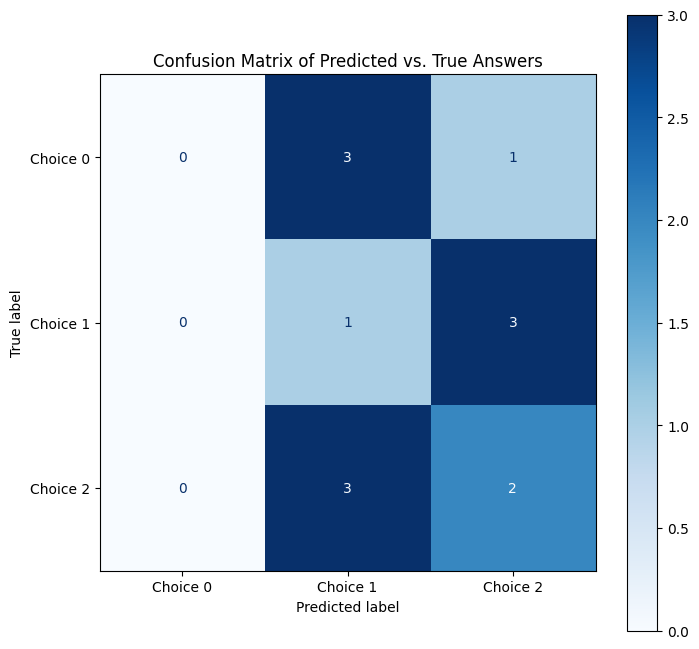

In [11]:
USE_KAGGLE = True

if USE_KAGGLE:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()

    Config.GROQ_API_KEY = user_secrets.get_secret("GROQ_API_KEY")
    Config.MONGO_URI = user_secrets.get_secret("MONGO_URI")

# Check for API key before running
if not Config.GROQ_API_KEY:
    print("GROQ_API_KEY is not set in the .env file. Evaluation cannot proceed.")
elif not Config.MONGO_URI:
    logging.error("MONGO_URI is not set in the .env file. Evaluation cannot proceed.")
else:
    # Load a sample of the eval dataset
    try:
        eval_df = pd.read_csv(Config.EVAL_DATA_PATH)
        # Use a small sample for quick testing, you can increase the fraction
        sample_df = eval_df.sample(frac=0.1, random_state=42)
        logging.info(f"Loaded {len(sample_df)} samples from {Config.EVAL_DATA_PATH}")
    except FileNotFoundError:
        logging.error(f"Evaluation file not found at {Config.EVAL_DATA_PATH}")
        sample_df = None

    if sample_df is not None:
        app = build_rag_graph()
        
        questions = []
        generated_answers = []
        ground_truths = []
        choices_list = []

        logging.info(f"Running evaluation on {len(sample_df)} samples...")
        # Use iterrows() for DataFrame iteration in a notebook for clarity
        for index, row in sample_df.iterrows():
            logging.info(f"Processing sample {index+1}/{len(sample_df)}: Question ID {row.name}")
            
            question = row["question"]
            ground_truth_choice = row["answer"]
            choices = row["choices"]
            
            # The input to the graph is a dictionary with keys matching the RAGState
            inputs = {"query": question, "conversation_history": ""}
            result = app.invoke(inputs)
            
            questions.append(question)
            generated_answers.append(result["answer"])
            ground_truths.append(ground_truth_choice)
            choices_list.append(choices)

        # Run the final evaluation and print the report
        evaluate_performance(questions, generated_answers, ground_truths, choices_list)